In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scipy scikit-learn

# Task 2: Hit Prediction - Data Preprocessing

**Objective:** Clean and preprocess the TMDB dataset for classification modeling.

**Key Steps:**
1. Load and explore the dataset
2. Handle missing values (19% in avg_rating and hit)
3. Detect and handle outliers
4. Create visualizations for data understanding
5. Save cleaned dataset for modeling

## 1. Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the dataset
df = pd.read_csv('tmdb_converted_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (3373, 6)

Columns: ['movie_id', 'avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'hit']

First few rows:


,movie_id,avg_watch_time,completion_rate,ratings_count,avg_rating,hit
0,19995,98,0.92,15573,4.5,1.0
1,285,71,0.74,6495,4.5,1.0
2,206647,64,0.73,6452,4.4,1.0
3,49026,85,0.86,12222,4.6,1.0
4,49529,50,0.67,3540,4.3,1.0


## 2. Initial Data Exploration

In [5]:
# Data types and info for feature columns only (exclude movie_id and hit)
feature_cols = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating']

print("Dataset Information (Feature Columns Only):")
print("=" * 50)
df[feature_cols].info()

print("\n" + "=" * 50)
print("\nBasic Statistics (Feature Columns Only):")
df[feature_cols].describe()

Dataset Information (Feature Columns Only):
<class 'pandas.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_watch_time   3373 non-null   int64  
 1   completion_rate  3373 non-null   float64
 2   ratings_count    3373 non-null   int64  
 3   avg_rating       2732 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 105.5 KB


Basic Statistics (Feature Columns Only):


,avg_watch_time,completion_rate,ratings_count,avg_rating
count,3373.000000,3373.000000,3373.000000,2732.000000
mean,44.389861,0.647269,2074.235102,4.352599
std,6.553737,0.040858,1732.486244,0.149687
min,40.000000,0.550000,900.000000,3.600000
25%,41.000000,0.620000,1099.000000,4.300000
50%,42.000000,0.640000,1447.000000,4.400000
75%,45.000000,0.660000,2257.000000,4.400000
max,150.000000,0.980000,18000.000000,4.700000


Missing Values Analysis:
                 Missing_Count  Missing_Percentage
movie_id                     0                 0.0
avg_watch_time               0                 0.0
completion_rate              0                 0.0
ratings_count                0                 0.0
avg_rating                 641                19.0
hit                        641                19.0


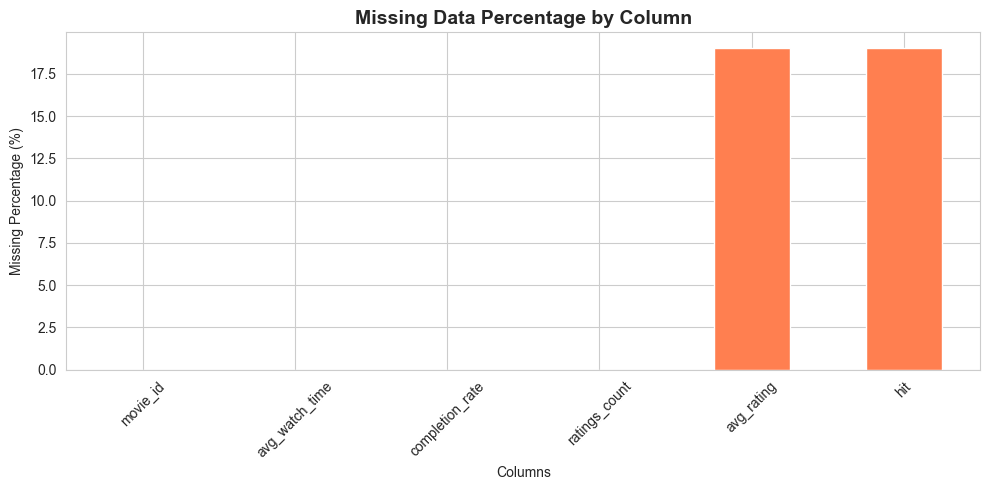


Total rows with missing values: 641


In [6]:
# Check for missing values
missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print("Missing Values Analysis:")
print("=" * 50)
print(missing_data)

# Visualize missing data
plt.figure(figsize=(10, 5))
missing_data['Missing_Percentage'].plot(kind='bar', color='coral')
plt.title('Missing Data Percentage by Column', fontsize=14, fontweight='bold')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nTotal rows with missing values: {df.isnull().any(axis=1).sum()}")

In [7]:
# Check for duplicate movie_ids
duplicates = df['movie_id'].duplicated().sum()
print(f"Duplicate movie_ids: {duplicates}")

if duplicates > 0:
    print("\nDuplicate movie_ids found:")
    print(df[df['movie_id'].duplicated(keep=False)].sort_values('movie_id'))

Duplicate movie_ids: 0


## 3. Handle Missing Values

In [8]:
# Analyze missingness pattern
print("Analyzing missingness pattern...")
print("=" * 50)

# Check if missing values occur together
missing_both = df[df['avg_rating'].isnull() & df['hit'].isnull()].shape[0]
missing_rating_only = df[df['avg_rating'].isnull() & df['hit'].notnull()].shape[0]
missing_hit_only = df[df['avg_rating'].notnull() & df['hit'].isnull()].shape[0]

print(f"Missing both avg_rating and hit: {missing_both}")
print(f"Missing only avg_rating: {missing_rating_only}")
print(f"Missing only hit: {missing_hit_only}")

print("\nConclusion: Missing values occur together in the same rows.")

Analyzing missingness pattern...
Missing both avg_rating and hit: 641
Missing only avg_rating: 0
Missing only hit: 0

Conclusion: Missing values occur together in the same rows.


In [9]:
# Store original shape
original_shape = df.shape

# Drop rows with missing target variable (hit)
# We cannot impute the target variable as we don't know the true labels
df_clean = df.dropna(subset=['hit']).copy()

print(f"Original dataset shape: {original_shape}")
print(f"After removing missing target: {df_clean.shape}")
print(f"Rows removed: {original_shape[0] - df_clean.shape[0]}")

# Check remaining missing values
print("\nRemaining missing values:")
print(df_clean.isnull().sum())

Original dataset shape: (3373, 6)
After removing missing target: (2732, 6)
Rows removed: 641

Remaining missing values:
movie_id           0
avg_watch_time     0
completion_rate    0
ratings_count      0
avg_rating         0
hit                0
dtype: int64


Target Variable Distribution (after cleaning):
hit
0.0    1907
1.0     825
Name: count, dtype: int64

Class Balance:
hit
0.0    0.698
1.0    0.302
Name: proportion, dtype: float64


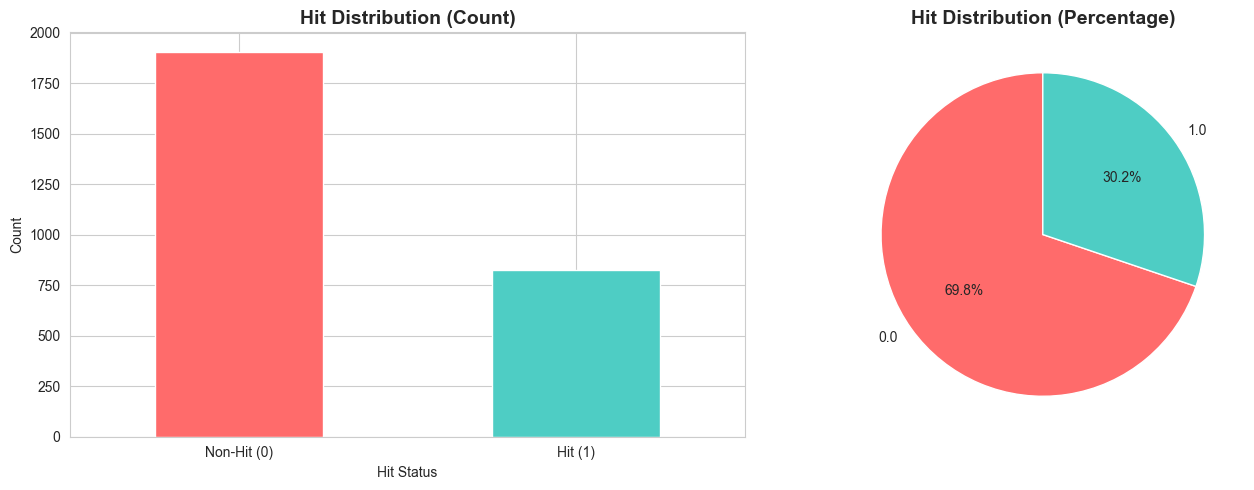

In [10]:
# Check target distribution after cleaning
print("Target Variable Distribution (after cleaning):")
print("=" * 50)
print(df_clean['hit'].value_counts())
print(f"\nClass Balance:")
print(df_clean['hit'].value_counts(normalize=True).round(3))

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df_clean['hit'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Hit Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hit Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Hit (0)', 'Hit (1)'], rotation=0)

# Pie chart
df_clean['hit'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                     colors=['#FF6B6B', '#4ECDC4'], startangle=90)
axes[1].set_title('Hit Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 4. Outlier Detection and Analysis

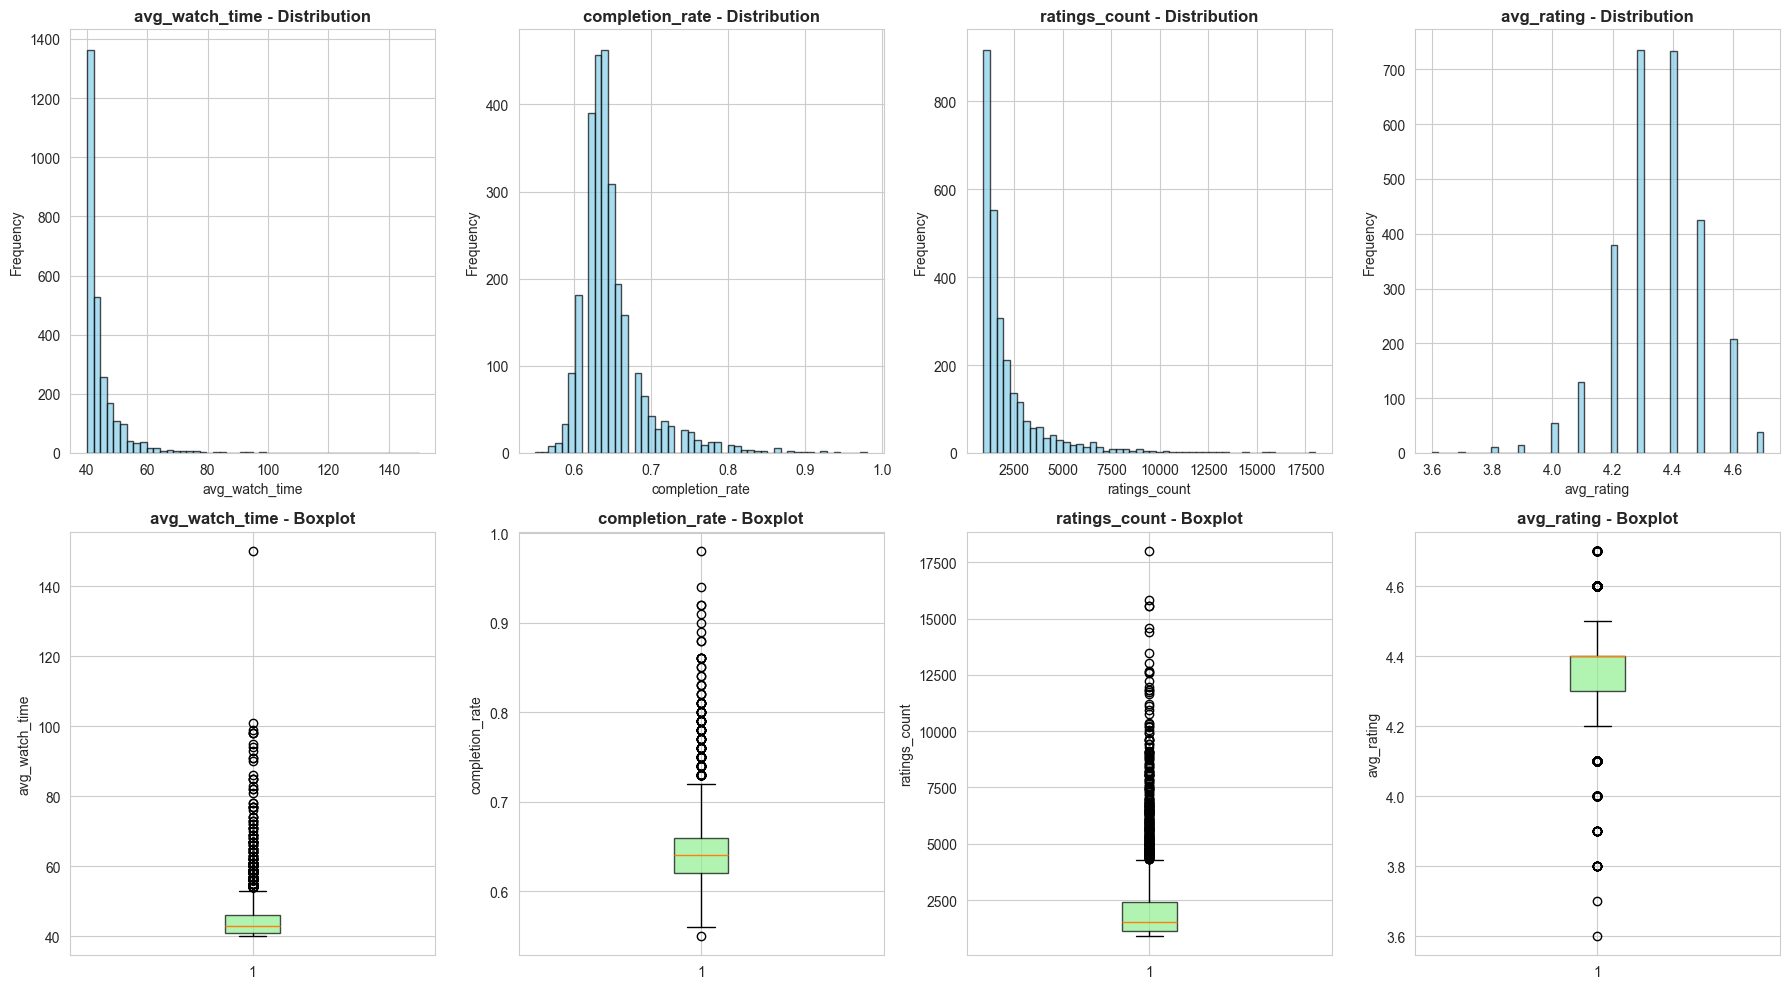

In [11]:
# Visualize distributions and detect outliers
numerical_cols = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Histogram
    axes[idx].hist(df_clean[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} - Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    
    # Boxplot
    axes[idx + 4].boxplot(df_clean[col], vert=True, patch_artist=True,
                          boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[idx + 4].set_title(f'{col} - Boxplot', fontweight='bold')
    axes[idx + 4].set_ylabel(col)

plt.tight_layout()
plt.show()

In [12]:
# Detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Outlier Analysis (IQR Method):")
print("=" * 70)

outlier_summary = []
for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    outlier_summary.append({
        'Column': col,
        'Outliers_Count': len(outliers),
        'Outliers_Percentage': f"{(len(outliers) / len(df_clean) * 100):.2f}%",
        'Lower_Bound': f"{lower:.2f}",
        'Upper_Bound': f"{upper:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

Outlier Analysis (IQR Method):
         Column  Outliers_Count Outliers_Percentage Lower_Bound Upper_Bound
 avg_watch_time             207               7.58%       33.50       53.50
completion_rate             172               6.30%        0.56        0.72
  ratings_count             267               9.77%     -769.50     4298.50
     avg_rating             457              16.73%        4.15        4.55


In [13]:
# Analyze outliers in context
# For movie data, high watch_time and ratings_count might be legitimate (blockbusters)
# We'll keep outliers but note them for feature engineering

print("Outlier Analysis Decision:")
print("=" * 50)
print("\nKeeping outliers because:")
print("1. High avg_watch_time and ratings_count likely represent blockbuster movies")
print("2. These are legitimate data points, not measurement errors")
print("3. They provide valuable information for hit prediction")
print("4. Tree-based models (RF, XGBoost) are robust to outliers")

# Show examples of potential outliers
print("\nExamples of high-value movies (potential blockbusters):")
print(df_clean.nlargest(5, 'ratings_count')[['movie_id', 'avg_watch_time', 'ratings_count', 'avg_rating', 'hit']])

Outlier Analysis Decision:

Keeping outliers because:
1. High avg_watch_time and ratings_count likely represent blockbuster movies
2. These are legitimate data points, not measurement errors
3. They provide valuable information for hit prediction
4. Tree-based models (RF, XGBoost) are robust to outliers

Examples of high-value movies (potential blockbusters):
     movie_id  avg_watch_time  ratings_count  avg_rating  hit
95      27205             101          18000         4.7  1.0
65        155              98          15824         4.7  1.0
0       19995              98          15573         4.5  1.0
16      24428              91          15543         4.6  1.0
755    293660              98          14572         4.3  0.0


## 5. Correlation Analysis

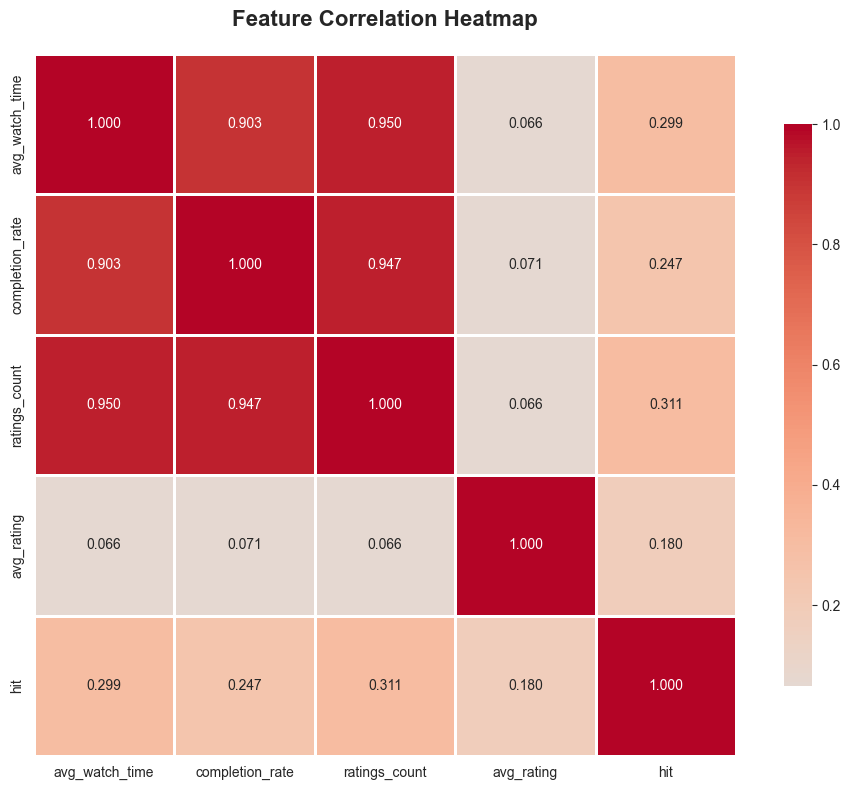


Correlations with Target Variable (hit):
hit                1.000000
ratings_count      0.311409
avg_watch_time     0.299281
completion_rate    0.247073
avg_rating         0.180088
Name: hit, dtype: float64


In [14]:
# Calculate correlation matrix
correlation_matrix = df_clean[numerical_cols + ['hit']].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show correlations with target
print("\nCorrelations with Target Variable (hit):")
print("=" * 50)
target_corr = correlation_matrix['hit'].sort_values(ascending=False)
print(target_corr)

## 6. Feature Distributions by Target Class

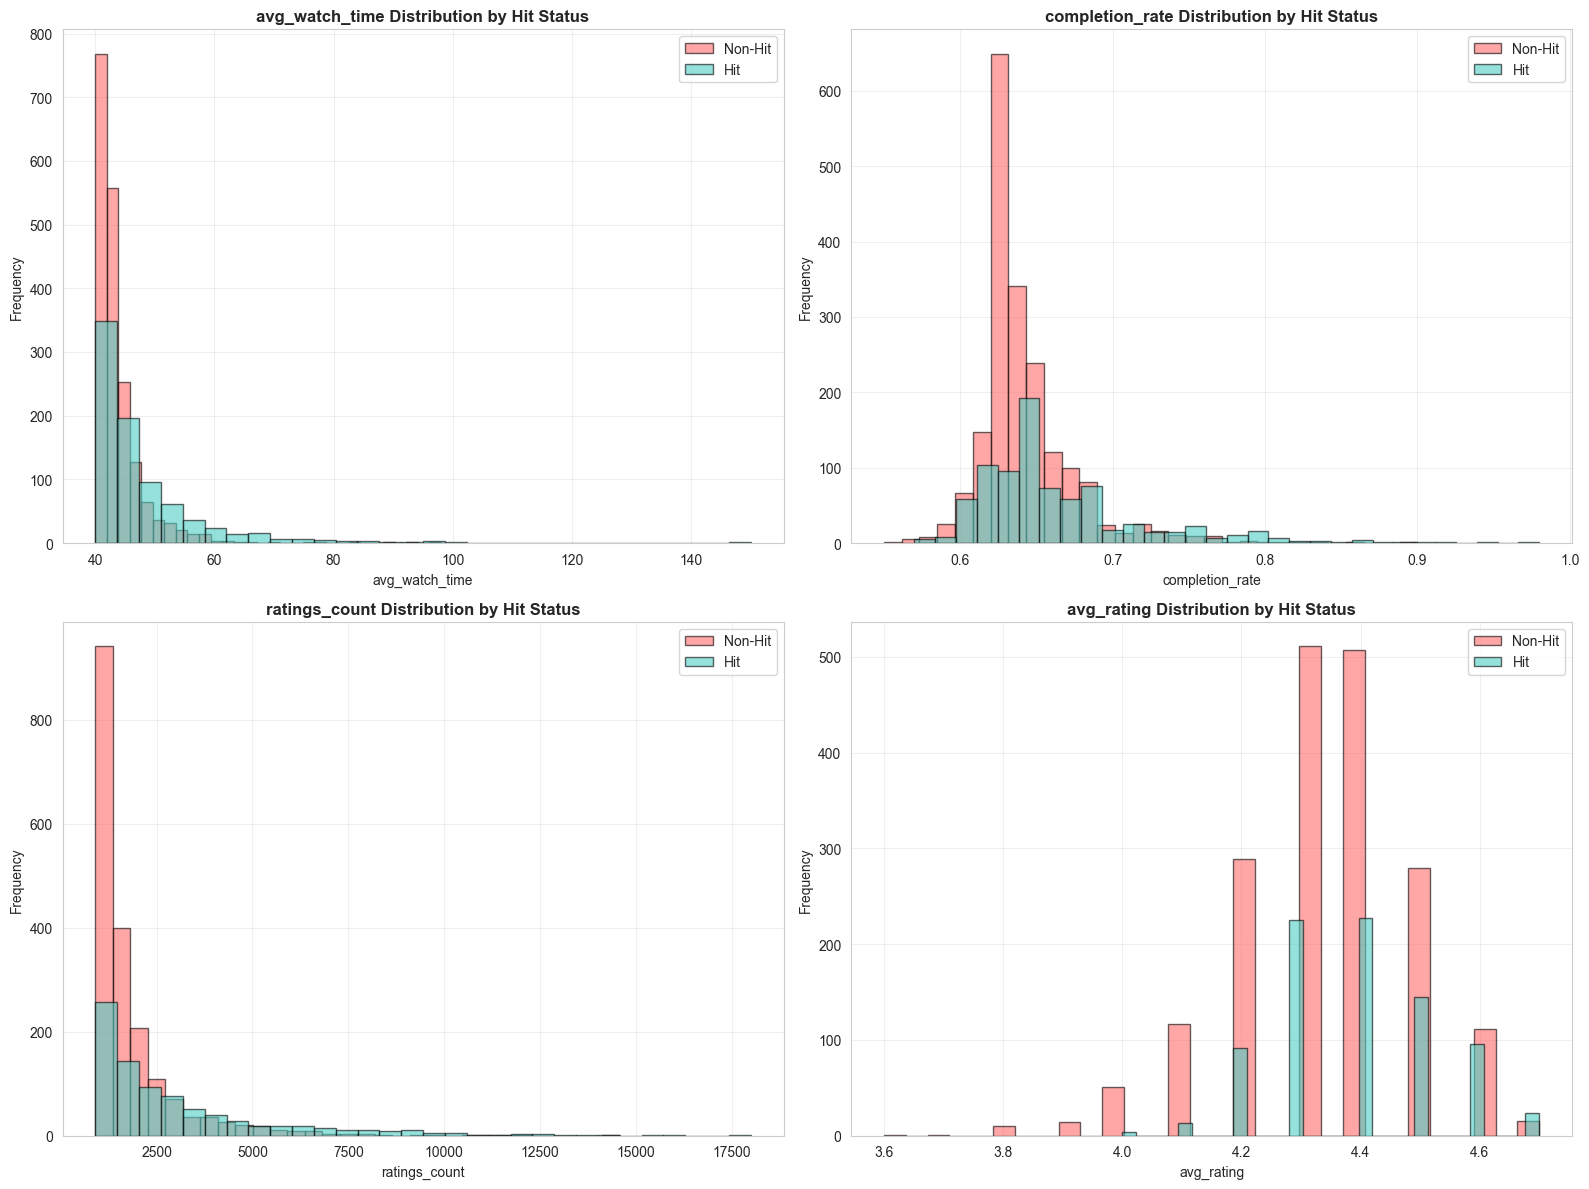

In [15]:
# Compare feature distributions between hits and non-hits
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Separate data by hit status
    hit_data = df_clean[df_clean['hit'] == 1][col]
    non_hit_data = df_clean[df_clean['hit'] == 0][col]
    
    # Plot overlapping histograms
    axes[idx].hist(non_hit_data, bins=30, alpha=0.6, label='Non-Hit', color='#FF6B6B', edgecolor='black')
    axes[idx].hist(hit_data, bins=30, alpha=0.6, label='Hit', color='#4ECDC4', edgecolor='black')
    axes[idx].set_title(f'{col} Distribution by Hit Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Statistical comparison between hits and non-hits
print("Statistical Comparison: Hits vs Non-Hits")
print("=" * 70)

comparison_stats = []
for col in numerical_cols:
    hit_mean = df_clean[df_clean['hit'] == 1][col].mean()
    non_hit_mean = df_clean[df_clean['hit'] == 0][col].mean()
    hit_median = df_clean[df_clean['hit'] == 1][col].median()
    non_hit_median = df_clean[df_clean['hit'] == 0][col].median()
    
    comparison_stats.append({
        'Feature': col,
        'Hit_Mean': f"{hit_mean:.2f}",
        'Non-Hit_Mean': f"{non_hit_mean:.2f}",
        'Hit_Median': f"{hit_median:.2f}",
        'Non-Hit_Median': f"{non_hit_median:.2f}"
    })

comparison_df = pd.DataFrame(comparison_stats)
print(comparison_df.to_string(index=False))

Statistical Comparison: Hits vs Non-Hits
        Feature Hit_Mean Non-Hit_Mean Hit_Median Non-Hit_Median
 avg_watch_time    47.96        43.40      44.00          42.00
completion_rate     0.67         0.64       0.65           0.64
  ratings_count  3050.31      1803.08    2100.00        1369.00
     avg_rating     4.39         4.33       4.40           4.30


## 7. Final Data Quality Check

In [17]:
# Final data quality summary
print("Final Data Quality Summary:")
print("=" * 50)
print(f"Total rows: {len(df_clean)}")
print(f"Total columns: {len(df_clean.columns)}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")
print(f"\nData types:")
print(df_clean.dtypes)

print("\n" + "=" * 50)
print("Data is clean and ready for feature engineering!")

Final Data Quality Summary:
Total rows: 2732
Total columns: 6
Missing values: 0
Duplicate rows: 0

Data types:
movie_id             int64
avg_watch_time       int64
completion_rate    float64
ratings_count        int64
avg_rating         float64
hit                float64
dtype: object

Data is clean and ready for feature engineering!


## 8. Save Preprocessed Dataset

In [18]:
# Save cleaned dataset
output_file = 'tmdb_preprocessed.csv'
df_clean.to_csv(output_file, index=False)

print(f"Preprocessed dataset saved as: {output_file}")
print(f"Shape: {df_clean.shape}")
print(f"\nColumns: {df_clean.columns.tolist()}")
print("\nPreprocessing complete!")

Preprocessed dataset saved as: tmdb_preprocessed.csv
Shape: (2732, 6)

Columns: ['movie_id', 'avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating', 'hit']

Preprocessing complete!


In [19]:
# Display final preview
print("Preview of preprocessed data:")
df_clean.head(10)

Preview of preprocessed data:


,movie_id,avg_watch_time,completion_rate,ratings_count,avg_rating,hit
0,19995,98,0.92,15573,4.5,1.0
1,285,71,0.74,6495,4.5,1.0
2,206647,64,0.73,6452,4.4,1.0
3,49026,85,0.86,12222,4.6,1.0
4,49529,50,0.67,3540,4.3,1.0
5,559,60,0.70,5346,4.3,1.0
6,38757,50,0.72,5040,4.6,1.0
7,99861,73,0.80,9314,4.5,1.0
8,767,67,0.77,7481,4.6,1.0
9,209112,78,0.78,9609,4.3,1.0
